In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from PIL import Image

import os

print(os.getcwd()) # dosya yolunu ver
%run ../Model.ipynb
%run ../Dataset.ipynb

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/arf/home/tunal/ondemand/PhD Thesis Starting/01_SON/Tik-4/Tez/07-CelebA/02-UAE_for_CelebA


In [2]:
# Veri yolu
root_dir = '../data/img_align_celeba/'
test_dataset  = CelebADataset(img_dir=root_dir, attr_path='../data/list_attr_celeba.csv', partition_path='../data/list_eval_partition.csv', mode='test')
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

In [3]:
# "results" klasörünü oluştur (zaten varsa hata vermez)
os.makedirs("results", exist_ok=True)

name = 'results/UAE_CelebA_HQ'
model_eval = torch.load(name + '.model', weights_only=False, map_location='cpu')
model_eval.eval()

To_Uniform(
  (encoder): SimpleEncoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=2048, bias=True)
      (1): SiLU

# MSE on Test Set

In [5]:
X_test = next(iter(test_loader))

# Test verisini modele ver
with torch.no_grad():
    z, x_hat = model_eval(X_test)   # X_test[:] yazman ile aynı

# MSE Loss nesnesi
mse_loss = nn.MSELoss()

# Ortalama MSE hesapla
mse = mse_loss(x_hat, X_test)

print("Test MSE:", mse.item())

# results klasörünü oluştur
os.makedirs("results", exist_ok=True)

# Dosyaya yaz
file_path = "results/test_mse.txt"
with open(file_path, "w") as f:
    f.write(f"Test MSE: {mse.item()}\n")

print(f"Test MSE results/ klasörüne kaydedildi: {file_path}")

Test MSE: 0.0038922170642763376
Test MSE results/ klasörüne kaydedildi: results/test_mse.txt


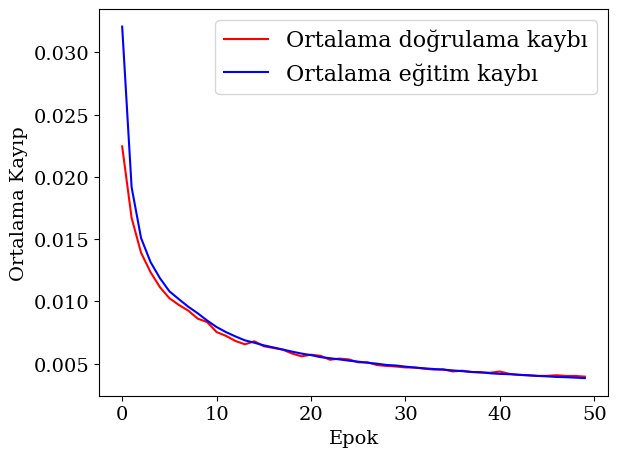

In [5]:
# Kayıpları yükle

losses = np.loadtxt("results/losses.csv", delimiter=",", skiprows=1)
train_losses = losses[:, 0]
val_losses = losses[:, 1]

# Grafik oluştur
plt.plot(val_losses, label="Ortalama doğrulama kaybı", c="red")
plt.plot(train_losses, label="Ortalama eğitim kaybı", c="blue")

plt.xlabel("Epok")
plt.ylabel("Ortalama Kayıp")
plt.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig("results/average_losses_per_epoch.pdf")
plt.show()


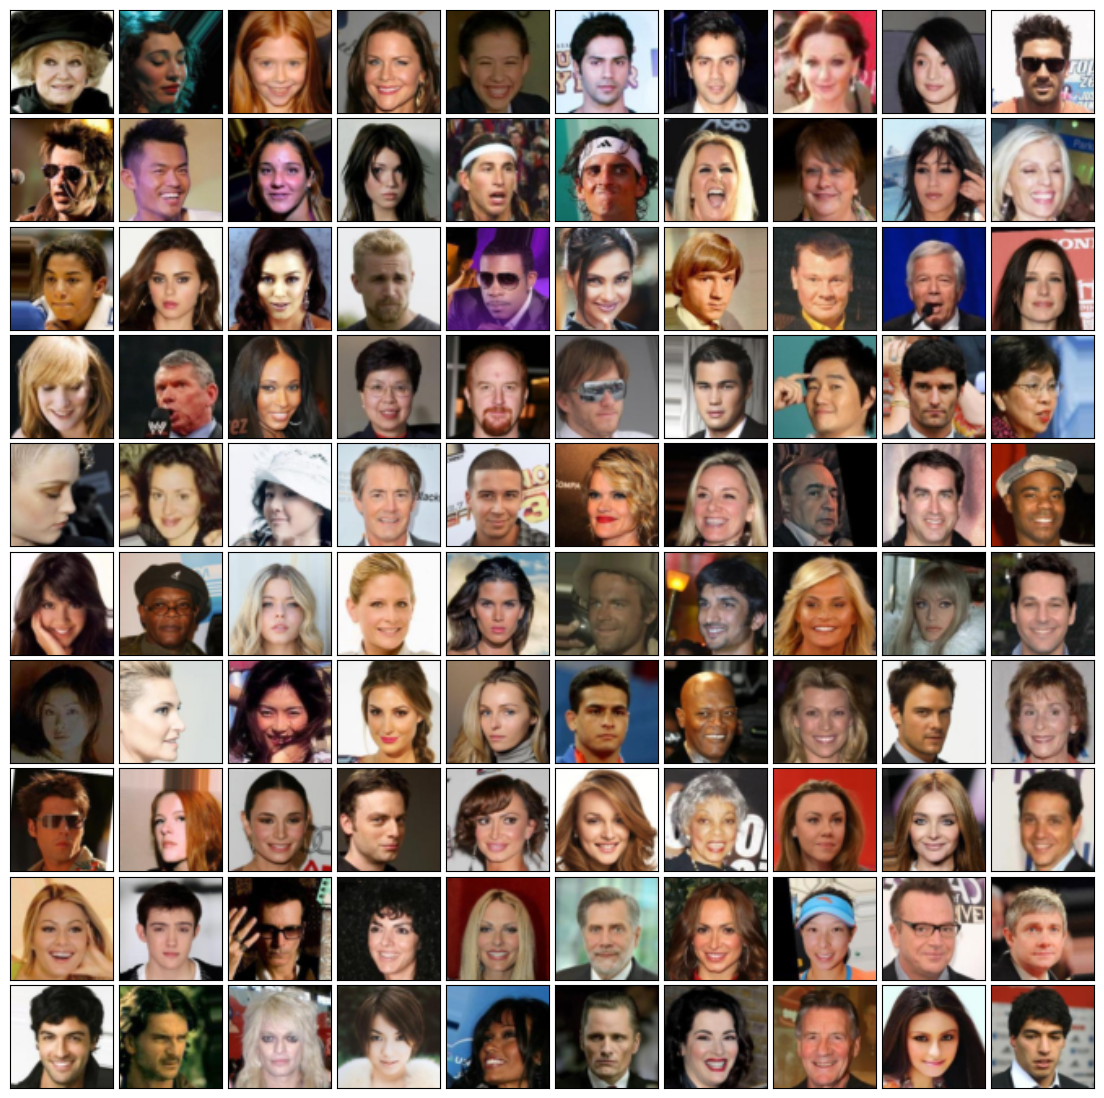

In [4]:
X_test = next(iter(test_loader))[0:100]


fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(X_test[idx].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy(), interpolation='bilinear')

plt.savefig('results/celebA_test_verisi_original.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

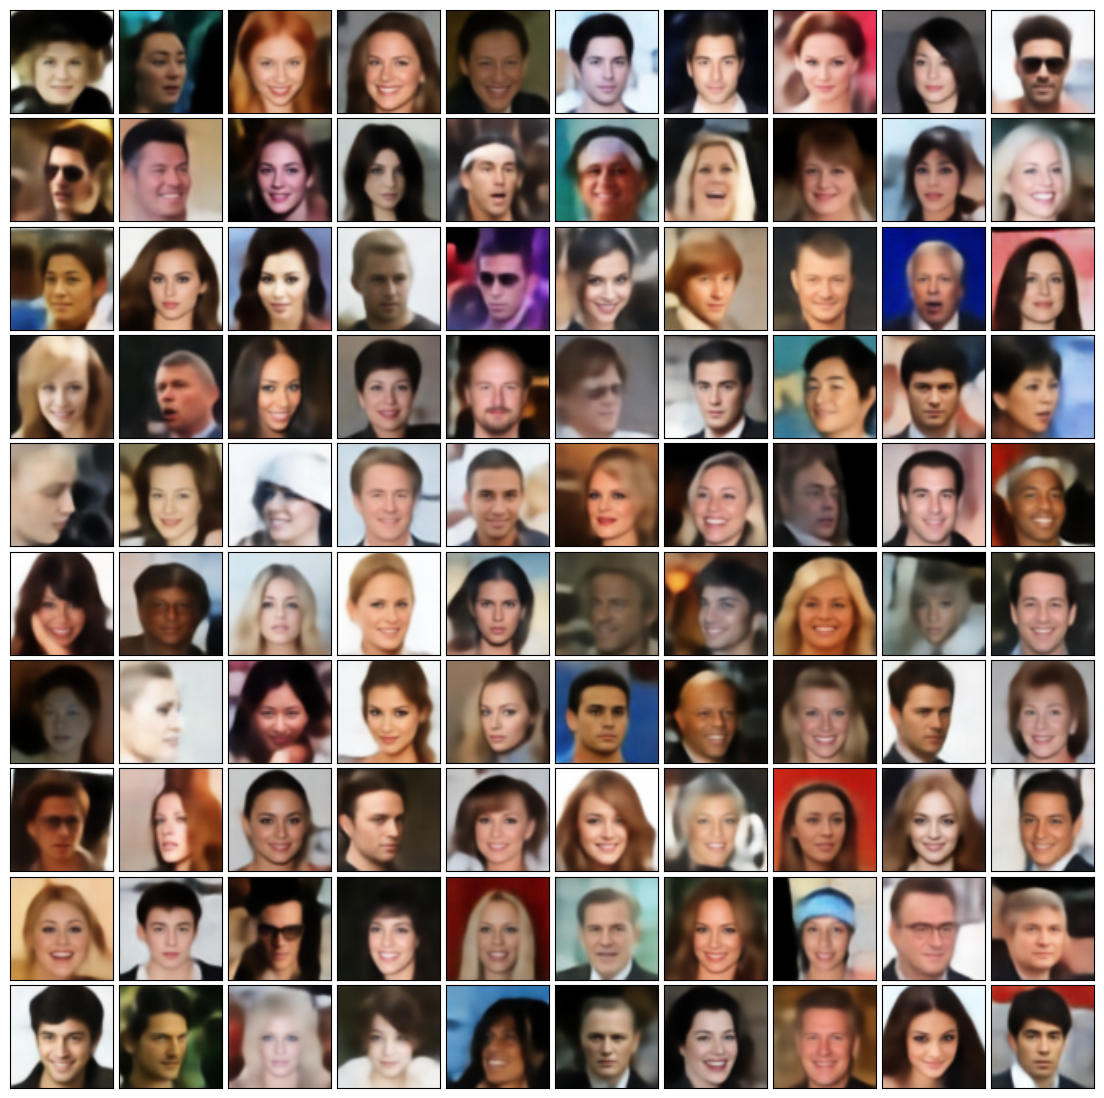

In [6]:
X_test = next(iter(test_loader))[0:100]
z, x_hat = model_eval(X_test)


fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axs[i, j].imshow(x_hat[idx].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy(), interpolation='bilinear')

plt.savefig('results/celebA_test_verisi_production.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

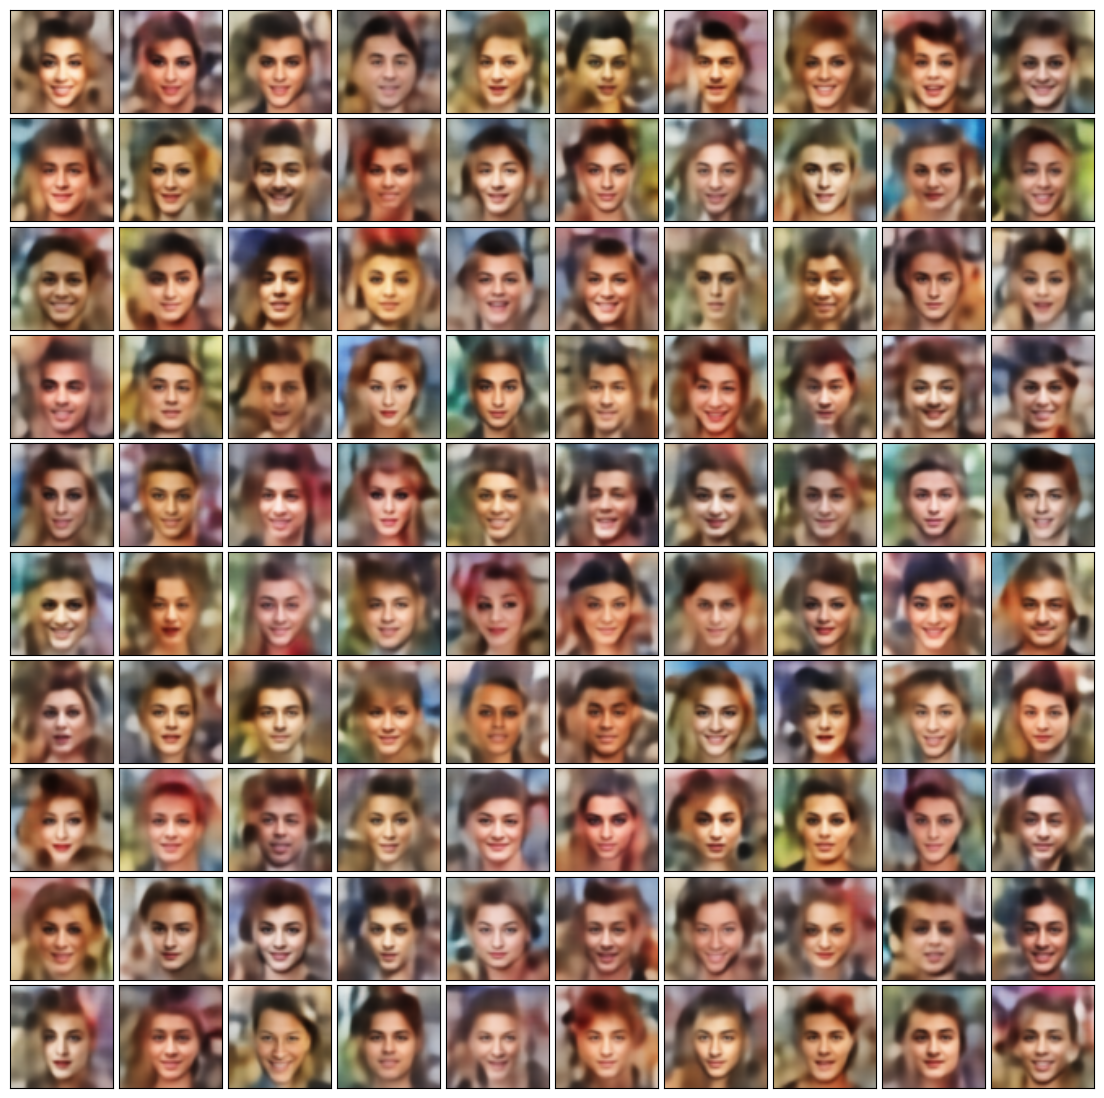

In [7]:
# Uniform latent dağılımdan örnek al
uniform_dist = torch.distributions.uniform.Uniform(low=torch.zeros(1024), high=torch.ones(1024))
latent_samples = uniform_dist.sample((100,))  # 5x10 grid için 50 örnek

# Decode et
x_hat = model_eval.decoder(latent_samples).view(-1, 3, 64, 64)

# Görselleştir
fig, axs = plt.subplots(10, 10, figsize=(14, 14), sharex=True, sharey=True,
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.05, wspace=0.05))

for i, ax in enumerate(axs.flat):
    img = x_hat[i].reshape(3, 64, 64).permute(1, 2, 0).detach().numpy()
    ax.imshow(img, interpolation='bilinear')

plt.savefig('results/celebA_data_uretimi_from_latent.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

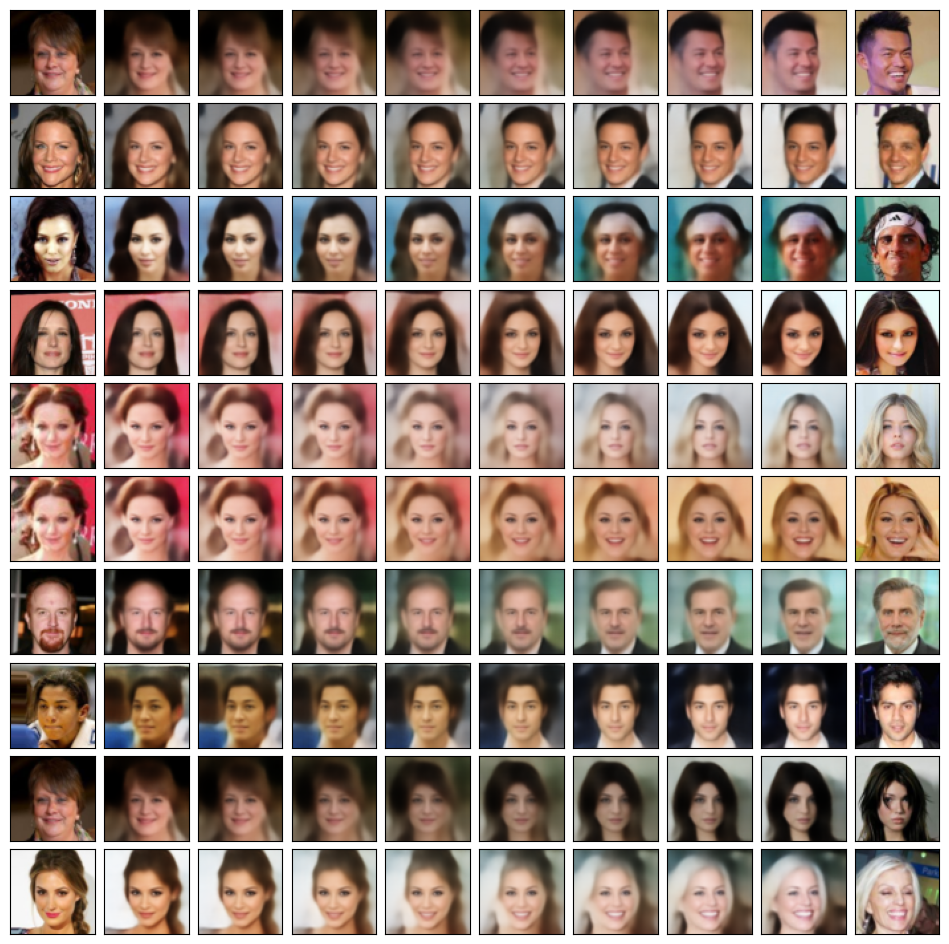

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def celeba_interpolation_random_pairs(model, X_tensor, device='cpu'):
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

    total_samples = len(X_tensor)

    for row in range(10):
        # Rastgele 2 örnek seç (etiket yok)
        idx1, idx2 = np.random.choice(total_samples, size=2, replace=False)
        img1 = X_tensor[idx1].unsqueeze(0).to(device)  # [1, 3, 64, 64]
        img2 = X_tensor[idx2].unsqueeze(0).to(device)

        with torch.no_grad():
            z1 = model.encoder(img1)
            z2 = model.encoder(img2)
            decoded_img1 = model.decoder(z1).squeeze(0).cpu()
            decoded_img2 = model.decoder(z2).squeeze(0).cpu()

        # 1. Orijinal img1
        axes[row, 0].imshow(img1.squeeze(0).cpu().permute(1, 2, 0).clip(0, 1).numpy())

        # 2. Decoded img1
        axes[row, 1].imshow(decoded_img1.permute(1, 2, 0).clip(0, 1).numpy())

        # 6 interpolasyon
        for i in range(6):
            alpha = (i + 1) / 7.0
            z_interp = (1 - alpha) * z1 + alpha * z2
            interp_img = model.decoder(z_interp).squeeze(0).cpu()
            axes[row, 2 + i].imshow(interp_img.permute(1, 2, 0).clip(0, 1).detach().numpy())

        # 9. Decoded img2
        axes[row, 8].imshow(decoded_img2.permute(1, 2, 0).clip(0, 1).numpy())

        # 10. Orijinal img2
        axes[row, 9].imshow(img2.squeeze(0).cpu().permute(1, 2, 0).clip(0, 1).numpy())

    plt.savefig('./results/celeba_interpolation_random_pairs.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

celeba_interpolation_random_pairs(model_eval, X_test, device='cpu')

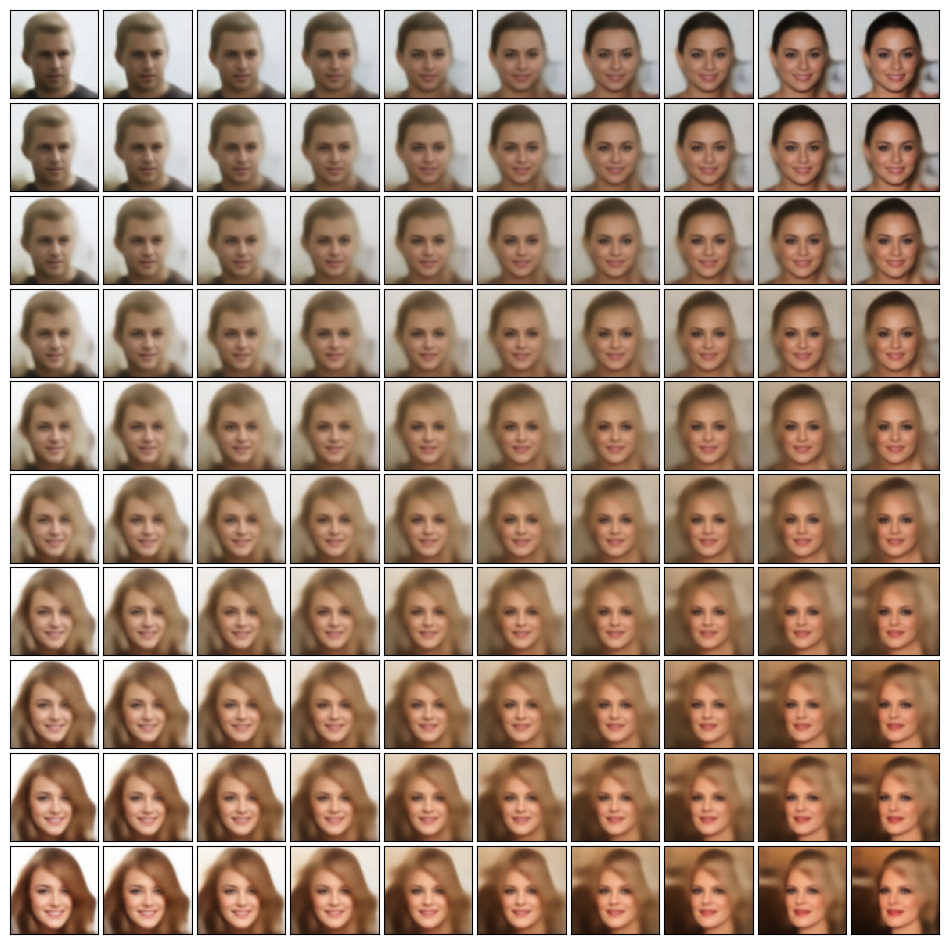

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y):
    """x, y ∈ [0, 1] - bilinear kombinasyon"""
    return (
        (1 - x) * (1 - y) * z_tl +
        x * (1 - y) * z_tr +
        (1 - x) * y * z_bl +
        x * y * z_br
    )

def celeba_corner_interpolation(model, data_tensor, device='cpu'):
    model.to(device)
    model.eval()

    total_samples = len(data_tensor)
    os.makedirs("results", exist_ok=True)

    # 4 rastgele örnek seç
    indices = np.random.choice(total_samples, size=4, replace=False)
    idx_tl, idx_tr, idx_bl, idx_br = indices

    # TXT dosyasına yaz
    with open("results/corner_celeba_info.txt", "w") as f:
        f.write("CelebA-HQ corner interpolasyon örnek indeksleri:\n\n")
        f.write(f"Top-Left     → index: {idx_tl}\n")
        f.write(f"Top-Right    → index: {idx_tr}\n")
        f.write(f"Bottom-Left  → index: {idx_bl}\n")
        f.write(f"Bottom-Right → index: {idx_br}\n")

    # Görselleri al ve encode et
    img_tl = data_tensor[idx_tl].unsqueeze(0).to(device)  # [1, 3, 64, 64]
    img_tr = data_tensor[idx_tr].unsqueeze(0).to(device)
    img_bl = data_tensor[idx_bl].unsqueeze(0).to(device)
    img_br = data_tensor[idx_br].unsqueeze(0).to(device)

    with torch.no_grad():
        z_tl = model.encoder(img_tl)
        z_tr = model.encoder(img_tr)
        z_bl = model.encoder(img_bl)
        z_br = model.encoder(img_br)

    # 10x10 görsel grid’i oluştur
    fig, axes = plt.subplots(10, 10, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

    for i in range(10):
        for j in range(10):
            x = j / 9.0  # yatay interpolasyon katsayısı
            y = i / 9.0  # dikey interpolasyon katsayısı
            z_interp = bilinear_interpolation(z_tl, z_tr, z_bl, z_br, x, y)

            with torch.no_grad():
                img = model.decoder(z_interp).squeeze(0).cpu()
                img_np = img.permute(1, 2, 0).clip(0, 1).numpy()  # [H,W,C]
                axes[i, j].imshow(img_np)

    plt.savefig('./results/celeba_corner_interpolation.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

celeba_corner_interpolation(model_eval, X_test, device='cpu')